# Notebook Imports

In [476]:
import sys

from os import walk
from os.path import join, basename
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import nltk
import numpy as np

from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


%matplotlib inline

# Constants

In [521]:
FILE_PATH = Path("SpamData/01_Processing")
TRAINING_PATH = Path("SpamData/02_Training")
SAC_PATH = FILE_PATH / "spam_assassin_corpus"
WORD_CLOUD_PATH = FILE_PATH / "wordcloud_resources"

# The PathLib should be converted to string for OS interpretation
PRACTICE_EMAIL = str(FILE_PATH / "practice_email.txt")
DATA_JSON_FILE = str(FILE_PATH / 'email-text-data.json')
WORD_ID_FILE = str(FILE_PATH / 'word-by-id.csv')
TRAINING_DATA_FILE = str(TRAINING_PATH / 'train-data.txt')
TEST_DATA_FILE = str(TRAINING_PATH / 'test-data.txt')

SPAM_1_PATH = str(SAC_PATH / "spam_1")
SPAM_2_PATH = str(SAC_PATH / "spam_2")
EASY_NONSPAM_1_PATH = str(SAC_PATH / "easy_ham_1")
EASY_NONSPAM_2_PATH = str(SAC_PATH / "easy_ham_2")

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

WHALE_FILE = str(WORD_CLOUD_PATH / "whale-icon.png")
SKULL_FILE = str(WORD_CLOUD_PATH / "skull-icon.png")
THUMBS_UP_FILE = str(WORD_CLOUD_PATH / "thumbs-up.png")
THUMBS_DOWN_FILE = str(WORD_CLOUD_PATH / "thumbs-down.png")

CUSTOM_FONT_FILE = str(WORD_CLOUD_PATH / "OpenSansCondensed-Bold.ttf")

# Reading Files

In [447]:
with open(PRACTICE_EMAIL, encoding='latin-1') as f:    
    message = f.read()
    print(type(message))
    print(message)


<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [248]:
sys.getfilesystemencoding()

'utf-8'

In [249]:
is_body = False
lines = []

with open(PRACTICE_EMAIL, 'r', encoding='latin-1') as f:    
    data = [line for line in f]
    
    for line in data:
        if is_body:
            lines.append(line)
        elif line == '\n':
            is_body = True

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [250]:
def get_email_body(path):
    is_body = False
    lines = []

    with open(path, 'r', encoding='latin-1') as f:    
        data = [line for line in f]

        for line in data:
            if is_body:
                lines.append(line)
            elif line == '\n':
                is_body = True
    
    email_body = '\n'.join(lines)
    
    return basename(path), email_body

In [251]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            
            yield get_email_body(filepath)

In [252]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [253]:
spam_emails = pd.concat([
    df_from_directory(SPAM_1_PATH, SPAM_CAT), 
    df_from_directory(SPAM_2_PATH, SPAM_CAT)
])
spam_emails.head()

ham_emails = pd.concat([
    df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT), 
    df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)
])
ham_emails.head()

data = pd.concat([spam_emails,ham_emails])

In [254]:
spam_emails.shape

(1898, 2)

In [255]:
ham_emails.shape

(3901, 2)

In [256]:
print('Shape of entire dataframe is:', data.shape)
data.head()

Shape of entire dataframe is: (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [257]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning: Checking for Missing Values

In [258]:
# Check if any message modies are null
data['MESSAGE'].isnull().values.any()

False

In [259]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [260]:
(data.MESSAGE.str.len() == 0).sum()

3

# Locate empty emails

In [261]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [262]:
data.drop(['cmds'], inplace=True)

In [263]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [264]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [265]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [266]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [267]:
data.to_json(DATA_JSON_FILE)

# Number of Spam messages Visualised (Pie charts)

In [268]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [269]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

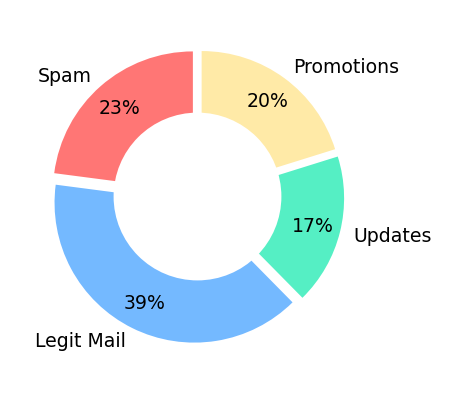

In [270]:
# category_names = ['Spam','Legit Mail']
category_names = ['Spam','Legit Mail', 'Updates', 'Promotions']
# sizes = [amount_of_spam, amount_of_ham]
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675','#74b9ff', '#55efc4','#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [271]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & Stopwords)

In [272]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OITAACMeineI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [273]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OITAACMeineI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [274]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\OITAACMeineI\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\OITAACMeineI\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenizing

In [275]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [276]:
stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [277]:
if 'this' in stop_words: print('Found it!')

Found it!


In [278]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


## Word Stems and Stemming

In [279]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english') 

filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]

## Removing Punctuation

In [280]:
'p'.isalpha()

True

In [281]:
'?'.isalpha()

False

In [282]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english') 

filtered_words = [stemmer.stem(word) 
                  for word in words 
                      if word 
                          not in stop_words 
                          and word.isalpha()]
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from HTML

In [283]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [284]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Functions for Email Processing

In [545]:
def clean_message(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):

    # Converts to lower case and splits up the words
    filtered_words = []
    
    message.lower()
    words = word_tokenize(message.lower())
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

def clean_message_no_html(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lower case and splits up the words
    filtered_words = []    
    
    words = word_tokenize(cleaned_text.lower())
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [354]:
clean_message_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenization to all Messages

### Slicing Dataframes and Series & Creating Subsets

In [355]:
data.iat[0,2]

'00001.7848dde101aa985090474a91ec93fcf0'

In [356]:
data.iloc[5:11]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [357]:
first_emails = data.MESSAGE.iloc[0:3]

# all data: data.MESSAGE.iloc[0:len(data)-1]

nested_list = first_emails.apply(clean_message)

In [358]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

321

In [359]:
# use apply() on all the mesages in the dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\OITAACMeineI\Documents\1. Projects\Community Care\outthere\udemy_python_ds_ml_bootcamp\.venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\OITAACMeineI\Documents\1. Projects\Community Care\outthere\udemy_python_ds_ml_bootcamp\.venv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [360]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [361]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [362]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [363]:
data[data.CATEGORY == 1].head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [364]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1891,1,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1894,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1895,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [365]:
doc_ids_spam = data[data.CATEGORY == SPAM_CAT].index
doc_ids_ham = data[data.CATEGORY == HAM_CAT].index

In [366]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [367]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [368]:
type(nested_list)

pandas.core.series.Series

In [369]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [370]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [371]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [372]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]

normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [373]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [448]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0] # total number of unique words in the non-spam messages

13242

In [449]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

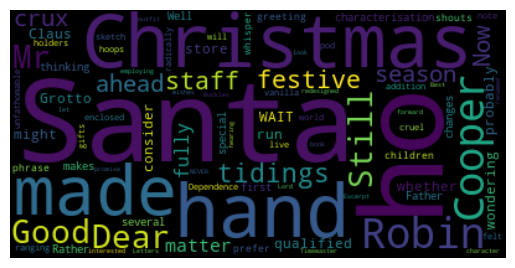

In [451]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()


In [452]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [453]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [454]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [455]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

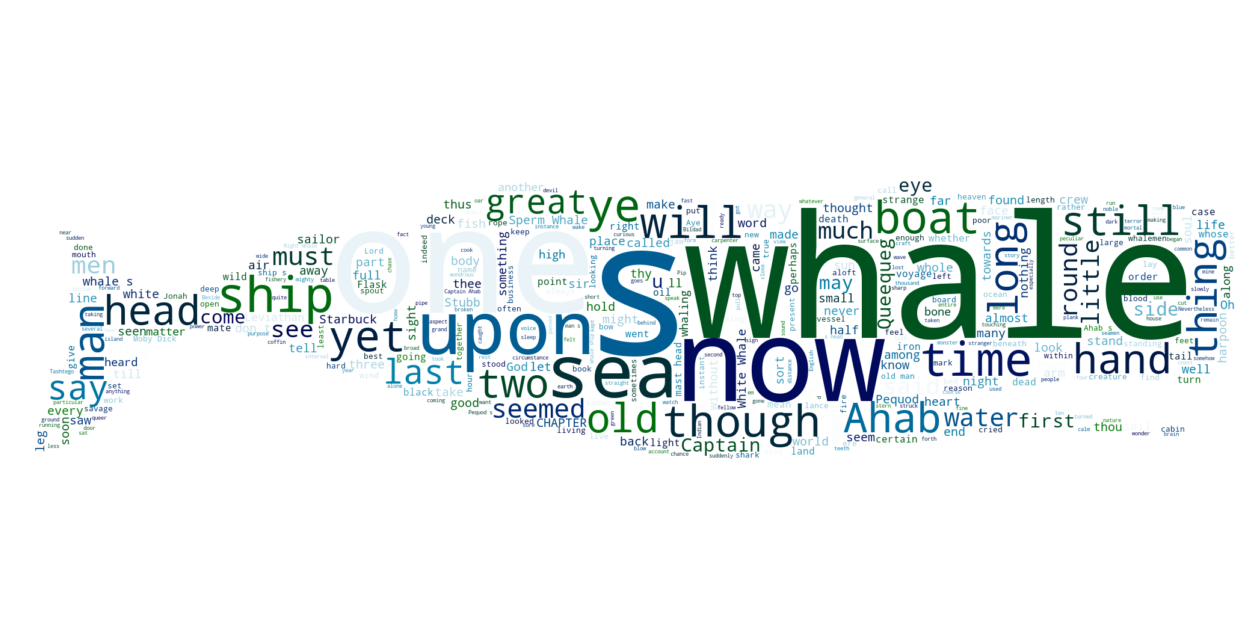

In [381]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #converts image obj to array


word_cloud = WordCloud(mask=rgb_array, 
                       background_color='white',
                       colormap='ocean',
                       max_words=400)
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

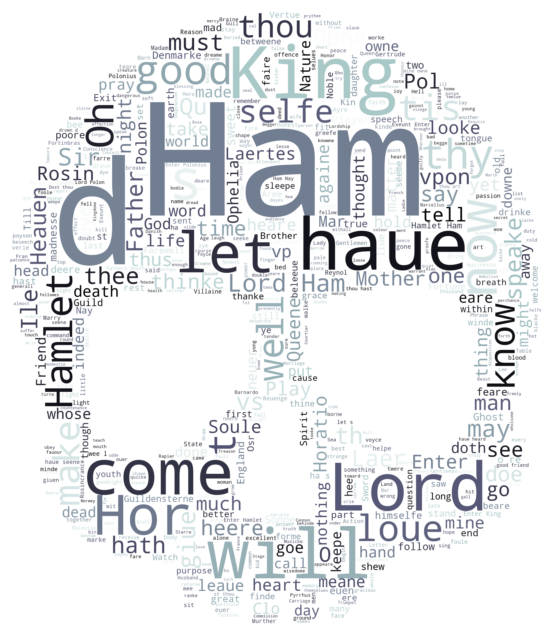

In [382]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask) #converts image obj to array


word_cloud = WordCloud(mask=rgb_array, 
                       background_color='white',
                       colormap='bone',
                       max_words=600)
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

# Word Cloud of Ham and Spam Messages

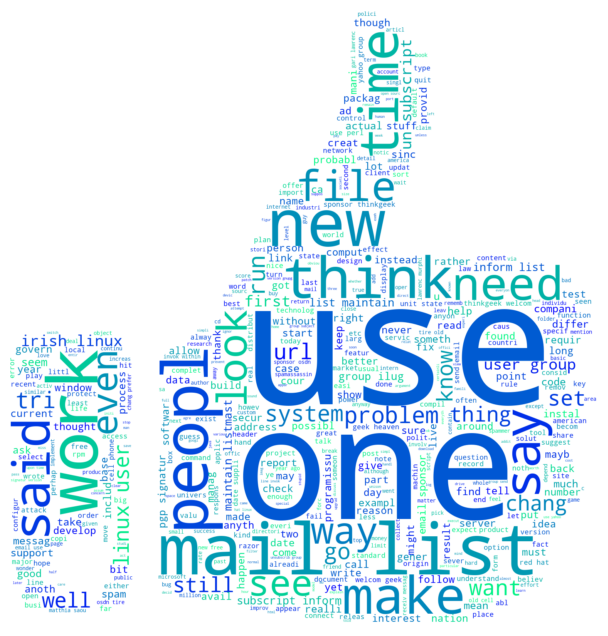

In [383]:
# flat_list_ham
thumbs_up_icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255, 255, 255))
image_mask.paste(thumbs_up_icon, box=thumbs_up_icon)
rgb_array = np.array(image_mask) #converts image obj to array
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, 
                       background_color='white',
                       colormap='winter',
                       max_words=500)
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

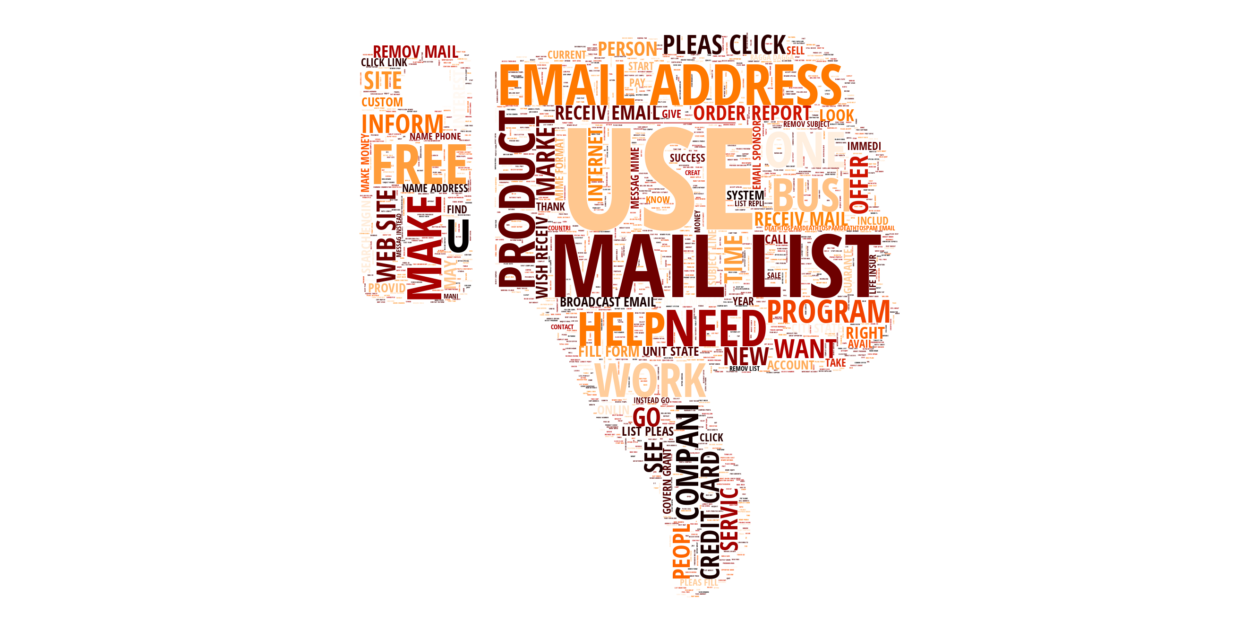

In [384]:
# flat_list_spam
thumbs_down_icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=thumbs_down_icon.size, color=(255, 255, 255))
image_mask.paste(thumbs_down_icon, box=thumbs_down_icon)
rgb_array = np.array(image_mask) #converts image obj to array
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, 
                       background_color='white',
                       colormap='gist_heat',
                       max_words=2000,
                       font_path=CUSTOM_FONT_FILE,
                       max_font_size=300)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

# Generate Vocabulary & Dictionary

In [389]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\OITAACMeineI\Documents\1. Projects\Community Care\outthere\udemy_python_ds_ml_bootcamp\.venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\OITAACMeineI\Documents\1. Projects\Community Care\outthere\udemy_python_ds_ml_bootcamp\.venv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [390]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [401]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [406]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [456]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [457]:
words_to_find = ['machine','learning','fun','learn','data','science','app','brewery']

any([word in words_to_find for word in set(vocab.VOCAB_WORD)])

True

# Exercise: Find the Email with the Most Number of Words

In [458]:
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [459]:
print(clean_email_lengths)

[92, 56, 44, 206, 45, 161, 47, 162, 203, 44, 55, 23, 44, 74, 64, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 18, 64, 95, 312, 56, 141, 72, 55, 1066, 48, 139, 2, 90, 78, 4, 47, 70, 44, 75, 38, 12, 38, 63, 47, 51, 71, 80, 25, 275, 36, 63, 19, 18, 14, 40, 57, 18, 77, 28, 102, 41, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 64, 253, 1221, 49, 0, 65, 52, 145, 15, 0, 90, 70, 2, 198, 50, 50, 50, 214, 119, 43, 80, 44, 319, 243, 9, 36, 98, 26, 52, 333, 47, 42, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 18, 129, 50, 0, 39, 74, 43, 72, 47, 80, 0, 28, 223, 97, 0, 58, 84, 214, 75, 47, 18, 104, 20, 114, 110, 187, 6, 40, 54, 79, 276, 110, 208, 6, 489, 62, 17, 175, 79, 47, 74, 82, 255, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1390, 108, 97, 25, 185, 1, 119, 255, 28, 137, 195, 177, 0, 98, 109, 1466, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 188, 77, 330, 14, 92, 92, 104, 372, 187, 241, 143, 254, 14, 98, 135, 223, 65, 90, 226, 217, 129, 38, 94, 204, 255, 215, 146,

In [460]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]

In [462]:
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [463]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5775


In [464]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [466]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [470]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [472]:
word_columns_df.shape

(5796, 7671)

## Splitting the Data into a Training and Testing Dataset

In [477]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, 
                                                    data.CATEGORY, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [479]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [483]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [484]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [485]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [486]:
word_index.get_loc('thu')

393

In [489]:
def make_sparse_matrix(df,indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category, 
                        'DOC_ID':doc_id, 
                        'OCCURENCE': 1, 
                        'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    

In [490]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [491]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1243
2,0,4844,1,502
3,0,4844,1,308
4,0,4844,1,254


In [492]:
sparse_train_df.shape

(429241, 4)

In [493]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429236,1,860,1,47
429237,1,860,1,1431
429238,1,860,1,26
429239,1,860,1,21
429240,1,860,1,126


### Combine Occurrences with the Pandas groupby() Method

In [510]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [511]:
vocab.at[0,'VOCAB_WORD']

'http'

In [512]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [513]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [514]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258355,5795,2035,0,2
258356,5795,2040,0,1
258357,5795,2272,0,1
258358,5795,2342,0,1
258359,5795,2370,0,1


In [515]:
vocab.at[2035,'VOCAB_WORD']

'swap'

In [516]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [517]:
train_grouped.shape

(258360, 4)

### Save Training Data as .txt File

In [519]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [520]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [522]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre-Processing Subtleties and Checking your Understanding

In [525]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [526]:
len(train_doc_ids)

4013

In [527]:
len(test_doc_ids)

1724

In [528]:
len(X_test)

1739

In [529]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}